In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import random
from tqdm import tqdm
import keras
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, Flatten, UpSampling2D, Reshape, core, Dropout, BatchNormalization, concatenate, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score, roc_curve, auc
import tensorflow as tf
from loss_functions_backend import jaccard_loss, iou_metric, recall, precision, f1, jaccard_coef_int
from np_metrics import np_jaccard_coef, np_recall, np_precision, np_f1
from keras.models import load_model
from keras.regularizers import l2 as l2_reg
import timeit
from objectwise_metrics import calculate_objectwise_metrics
from utils import pad_int_zeros
from train_nn_utils.models import CDnet_unguided_pooling
from train_nn_utils.generators import BatchGeneratorStatic
%matplotlib inline

Using TensorFlow backend.


In [2]:
PATCHES_DIR = '../data/aicd_patches/fixed_test_newAug_testR=0.1_valT=0.2_numSamples=30/'
RESULT_DIR = './train_results/aicd/aug_lib_augmentation/'
smooth = 1e-12

In [3]:
# LOADING PATCHES
train_dir = PATCHES_DIR+'train/'
train_data = os.listdir(PATCHES_DIR+'train/1')
val_dir = PATCHES_DIR+'val/'
val_data = os.listdir(PATCHES_DIR+'val/1')

In [4]:
model = CDnet_unguided_pooling((192, 240, 6)).get_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192, 240, 6)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 240, 6)       24        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 240, 64)      18880     
_________________________________________________________________
batch_normalization_2 (Batch (None, 192, 240, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 192, 240, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 120, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 120, 128)      401536    
__________

In [5]:
MAX_WORSE_EPOCHS = 5

weight_dir = RESULT_DIR + 'weights/'

In [ ]:
def train_nn(max_worse_epochs=MAX_WORSE_EPOCHS):
    prev_val_iou=0
    learning_rate = 0.01
    weghts_caption = ''
    prev_epoch_num = 0
    current_epoch_num = 1
    bad_epochs = 0

    while True:
        print('Epoch {}'.format(str(current_epoch_num)))
        optimizer = keras.optimizers.SGD(lr=learning_rate)
        model.compile(loss=jaccard_loss, optimizer=optimizer, metrics=[jaccard_coef_int, iou_metric, precision, recall, f1])
        batch_size = 10
        training_generator = BatchGeneratorStatic(batch_size = batch_size).generate(train_dir, train_data)
        validation_generator = BatchGeneratorStatic(batch_size = batch_size).generate(val_dir, val_data)

        fit_results = model.fit_generator(generator = training_generator,
                                steps_per_epoch = 400,
                                validation_data = validation_generator,
                                validation_steps = int(len(val_data)//batch_size), verbose = True,epochs= 1)
        metrics_dict = fit_results.history
        if metrics_dict['val_iou_metric'][0] > prev_val_iou:
            bad_epochs = 0
            prev_val_iou = metrics_dict['val_iou_metric'][0]
            
            try:
                os.mkdir(weight_dir)
            except FileExistsError:
                pass
            weghts_caption = weight_dir+'epoch{}-{}_weights_lr_{}_train{}iou_val{}iou.4f'.format(str(current_epoch_num), str(prev_epoch_num), learning_rate, round(metrics_dict['iou_metric'][0], 4),
                                                                                       round(metrics_dict['val_iou_metric'][0], 4))
            model.save_weights(weghts_caption)
        else:
            bad_epochs += 1
            learning_rate /= 2
            model.load_weights(weghts_caption)
        
        prev_epoch_num = current_epoch_num
        current_epoch_num += 1
        if bad_epochs >= MAX_WORSE_EPOCHS:
            break

In [ ]:
train_nn()

Epoch 1
Epoch 1/1
118/400 [=======>......................] - ETA: 3:17 - loss: 2.7070 - jaccard_coef_int: 0.0087 - iou_metric: 0.0087 - precision: 0.0114 - recall: 0.6533 - f1: 0.0223

In [ ]:
model.save("version_2_1/models/model_after_20.h5")

In [43]:
fit_results.history

{'f1': [nan],
 'iou_metric': [0.046460526836390202],
 'jaccard_coef_int': [0.04646043696266134],
 'loss': [2.6593033772706987],
 'precision': [0.09942082928730088],
 'recall': [0.63072432607848894],
 'val_f1': [nan],
 'val_iou_metric': [0.11832720245674615],
 'val_jaccard_coef_int': [0.11832706198015092],
 'val_loss': [2.5753893789492155],
 'val_precision': [0.19028585957697175],
 'val_recall': [0.63354526431250724]}

In [34]:
model.save_weights('weights/aicd-7-6weights_1ep_00005lr_tr06916iou_val07026iou.4f')

In [11]:
model.load_weights('version_2_1/weights/aicd_epoch26-24_weights_lr_7.8125e-05_train0.7595iou_val0.7561iou.4f')

In [12]:
# LOADING DATASETS
train_dir = DATASET_DIR+'train/'
train_data = os.listdir(DATASET_DIR+'train/1')
val_dir = DATASET_DIR+'val/'
val_data = os.listdir(DATASET_DIR+'val/1')
test_dir = DATASET_DIR+'test/'
test_data = os.listdir(DATASET_DIR+'test/1')

In [13]:
mode='test'
all_img=True

if mode=='val':
    data_dir=val_dir
    data=val_data
elif mode=='train':
    data_dir=train_dir
    data=train_data
elif mode=='test':
    data_dir=test_dir
    data=test_data
    
len_data=len(data)
if not all_img:
    len_data = 100

X = np.empty((len_data, 192, 240, 6))
y = np.empty((len_data, 192, 240))

# Generate data
for i in range(len_data):
    # Store volume
    img_1 = cv2.imread(data_dir+'1/'+data[i])
    img_2 = cv2.imread(data_dir+'2/'+data[i])
    img_gt = cv2.imread(data_dir+'gt/'+data[i],0)

    #print(img.shape)
    X[i, :, :, :3] = img_1/255
    X[i, :, :, 3:] = img_2/255

    y[i, :, :]=img_gt/255


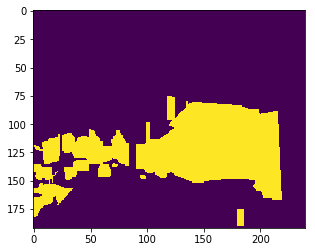

In [26]:
plt.imshow(y[0,:,:])

In [18]:
%timeit y_pred = model.predict(X)

6.26 s ± 294 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
batch_size = 5

y_pred = np.empty((len(data), 192, 240))

for i in tqdm(range(0, len(data), batch_size)):
    y_pred[i:i+batch_size,:,:] = model.predict(X[i:i+batch_size,:,:])

100%|██████████| 20/20 [00:04<00:00,  4.01it/s]


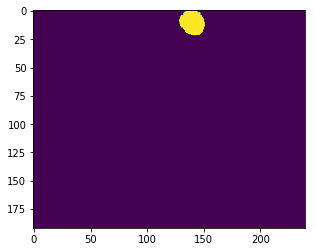

In [23]:
plt.imshow(y_pred[0,:,:])

In [14]:
#predict for test, for whole images
dataset_dir = '../data/AICDDataset/'
imgs_pred = []
imgs_gt = []
img_names = []
for scene_id in tqdm(range(95,100)):
    for view in tqdm(range(5)):
        img_path = 'Scene{}_View{}'.format(pad_int_zeros(scene_id, 4), pad_int_zeros(view, 2))
        img, img_gt = split_image(dataset_dir, img_path, model)
        imgs_pred.append(img)
        imgs_gt.append(img_gt)
        img_names.append(img_path)

100%|██████████| 5/5 [00:24<00:00,  4.84s/it]


In [26]:
# write predicted to images, include gt
RESULT_DIR='version_2_1/result/'
assert len(imgs_pred) == len(imgs_gt)
assert len(imgs_pred) == len(img_names)
for i in range(len(imgs_pred)):
    plt.imsave(RESULT_DIR+img_names[i]+'_gt.png', imgs_gt[i])
    plt.imsave(RESULT_DIR+img_names[i]+'_pred.png', imgs_pred[i])

In [89]:
imgs_gt[0].shape[0]

600

In [15]:
assert len(imgs_pred) == len(imgs_gt)
y_gt = np.empty((len(imgs_gt), imgs_gt[0].shape[0], imgs_gt[0].shape[1]))
y_pred = np.empty((len(imgs_pred), imgs_pred[0].shape[0], imgs_pred[0].shape[1]))
for i in range(len(imgs_pred)):
    y_gt[i, :, :] = imgs_gt[i]/255
    y_pred[i, :, :] = imgs_pred[i]
    
print(np_jaccard_coef(y_pred, y_gt))
print(np_precision(y_pred, y_gt))
print(np_recall(y_pred,y_gt))
print(np_f1(y_pred,y_gt))
print('------------------------------------')

0.686858151476
0.741661613099
0.902868593124
0.814363852556
------------------------------------


In [22]:
img_=img.reshape(224, 1024, 1)
img_gt_=img_gt.reshape(224, 1024, 1)

In [95]:
np.max(y_gt[0,:,:])

255.0

In [59]:
fpr, tpr, thresholds = roc_curve(y.reshape(-1), y_pred.reshape(-1))

In [60]:
auc(fpr, tpr)

0.96270553848825235

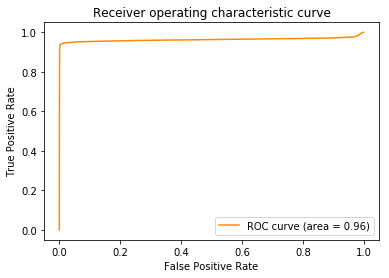

In [62]:
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [86]:
model.save("version_2/models/model.h5")

In [15]:
model = load_model("version_2/models/model.h5")

ValueError: Unknown loss function:jaccard_loss

In [17]:
# objectwise metrics
TP=0
FN=0
FP=0
for scene_id in tqdm(range(95,100)):
    for view in tqdm(range(5)):
        img_path = 'version_2_1/result/Scene{}_View{}'.format(pad_int_zeros(scene_id, 4), pad_int_zeros(view, 2))
        tmp_TP, tmp_FP, tmp_FN = calculate_objectwise_metrics(img_path+'_pred.png', img_path+'_gt.png')
        TP += tmp_TP
        FN += tmp_FN
        FP += tmp_FP

100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


In [18]:
TP, FP, FN

(20, 5, 5)

In [19]:
2*TP/(2*TP+FP+FN)

0.8